# Промышленность

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургического комбината «Стальная птица» требуется уменьшить потребление электроэнергии на этапе обработки стали. Для этого требуется контролировать температуру сплава.

Задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

### Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

In [2980]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from pathlib import Path
from sqlalchemy import create_engine, text

In [2981]:
# Определим переменные
RANDOM_STATE = 190923
# папка для хранения временных данных
TMP='./cache'
# Использование данных из кэша
USE_CACHE=False

In [2982]:
# создаём временный каталог для хранения данных
Path(TMP).mkdir(parents=True, exist_ok=True)

In [2983]:
# проверка кэша
onlyfiles = [f for f in listdir(TMP) if isfile(join(TMP, f))]

onlyfiles

['steel.data_arc.csv',
 'steel.data_bulk.csv',
 'steel.data_bulk_time.csv',
 'steel.data_gas.csv',
 'steel.data_temp.csv',
 'steel.data_wire.csv',
 'steel.data_wire_time.csv']

In [2984]:
USE_CACHE = len(onlyfiles) > 0

## Подключение к базе данных

In [2985]:
db_config = {
    'user': 'praktikum_student',# имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',# пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения
    'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)
conn = engine.connect()

In [2986]:
query = text('''
SELECT * FROM information_schema.tables AS t
WHERE t.table_schema = 'steel';
''')

tables_df = pd.read_sql_query(query, conn)

tables_df

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,data-science-final,steel,data_arc,BASE TABLE,None,None,None,None,None,YES,NO,None
1,data-science-final,steel,data_bulk,BASE TABLE,None,None,None,None,None,YES,NO,None
2,data-science-final,steel,data_bulk_time,BASE TABLE,None,None,None,None,None,YES,NO,None
3,data-science-final,steel,data_gas,BASE TABLE,None,None,None,None,None,YES,NO,None
4,data-science-final,steel,data_temp,BASE TABLE,None,None,None,None,None,YES,NO,None
5,data-science-final,steel,data_wire,BASE TABLE,None,None,None,None,None,YES,NO,None
6,data-science-final,steel,data_wire_time,BASE TABLE,None,None,None,None,None,YES,NO,None


### Описание данных

База данных состоит из нескольких таблиц:
* steel.data_arc — данные об электродах;
* steel.data_bulk — данные об объёме сыпучих материалов;
* steel.data_bulk_time — данные о времени подачи сыпучих материалов;
* steel.data_gas — данные о продувке сплава газом;
* steel.data_temp — данные об измерениях температуры;
* steel.data_wire — данные об объёме проволочных материалов;
* steel.data_wire_time — данные о времени подачи проволочных материалов.

__Таблица steel.data_arc__
* key — номер партии;
* BeginHeat — время начала нагрева;
* EndHeat — время окончания нагрева;
* ActivePower — значение активной мощности;
* ReactivePower — значение реактивной мощности.

__Таблица steel.data_bulk__
* key — номер партии;
* Bulk1 … Bulk15 — объём подаваемого материала.

__Таблица steel.data_bulk_time__
* key — номер партии;
* Bulk1 … Bulk15 — время подачи материала.

__Таблица steel.data_gas__
* key — номер партии;
* gas — объём подаваемого газа.

__Таблица steel.data_temp__
* key — номер партии;
* MesaureTime — время замера;
* Temperature — значение температуры.

__Таблица steel.data_wire__
* key — номер партии;
* Wire1 … Wire15 — объём подаваемых проволочных материалов.

__Таблица steel.data_wire_time__
* key — номер партии;
* Wire1 … Wire15 — время подачи проволочных материалов.

Во всех таблицах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Первичное исследование таблиц

Чтобы не загружать базу данных запросами, сохраним информацию в "локальном кэше"

In [2987]:
# создадим вспомогательные функции

def query_fast(query):
    """
    Быстрое выполнение запроса
    
    Параметры:
    ----------
    query: text - запрос
    """
    return pd.read_sql_query(text(query), conn)

def query_info(query, limit=5):
    """
    Получение простой информации по запросу
    
    Параметры:
    ----------
    query: text - запрос
    where: text - условие
    limit: integer - количество записей для вывода
    """
    table_query = text(f'{query} LIMIT {limit};')
    table_df = pd.read_sql_query(table_query, conn)
    display(table_df)
    
    table_count_query = text(f'{query.replace("*", "COUNT(*)")};')
    table_count_df = pd.read_sql_query(table_count_query, conn)
    print(f"Общее количество записей: {table_count_df.loc[0, 'count']}")

In [2988]:
# проверим все талбицы на наличие данных и сохраним результаты в локальное хранилище
tables = [
    'steel.data_arc', 
    'steel.data_bulk', 
    'steel.data_bulk_time', 
    'steel.data_gas', 
    'steel.data_temp', 
    'steel.data_wire', 
    'steel.data_wire_time'
]

if not USE_CACHE:
    for table in tables:
        query_info(f'SELECT * FROM {table}')
    
    # Так как количество данных в таблицах не столь велико, то сохраним данные в кэше
    for table in tables:
        query_fast(f'SELECT * FROM {table}').to_csv(TMP + f'/{table}.csv', index=False)
    
    USE_CACHE = True
else:
    print('Данные будут получены из локального кэша')

Данные будут получены из локального кэша


In [2989]:
# закрываем соединение
engine.dispose()

#### Данные об электродах

__Таблица steel.data_arc__
* key — номер партии;
* BeginHeat — время начала нагрева;
* EndHeat — время окончания нагрева;
* ActivePower — значение активной мощности;
* ReactivePower — значение реактивной мощности.

In [2990]:
data_arc = pd.read_csv(TMP + '/steel.data_arc.csv')

display(data_arc.head())

print()

data_arc.info()

print()

data_arc.describe()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB



,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [2991]:
# определим вспомогательные функции

def total_seconds(x):
    """
    Вспомогательная функция для подсчёта секунд
    
    Параметры:
    ----------
    x: datetime.time
    
    Результат:
    ----------
    int - общее количество секунд
    """

    return (x.hour * 3600) + (x.minute * 60) + x.second

In [2992]:
# обработаем поля со временем
data_arc['BeginHeat'] = pd.to_datetime(data_arc['BeginHeat'], format='%H:%M:%S')
data_arc['BeginHeatHour'] = data_arc['BeginHeat'].dt.hour
data_arc['BeginHeat'] = data_arc['BeginHeat'].dt.time

data_arc['EndHeat'] = pd.to_datetime(data_arc['EndHeat'], format='%H:%M:%S')
data_arc['EndHeatHour'] = data_arc['EndHeat'].dt.hour
data_arc['EndHeat'] = data_arc['EndHeat'].dt.time

# переведём временные значения в секунды
data_arc['BeginHeatSeconds'] = data_arc['BeginHeat'].apply(total_seconds)
data_arc['EndHeatSeconds'] = data_arc['EndHeat'].apply(total_seconds)

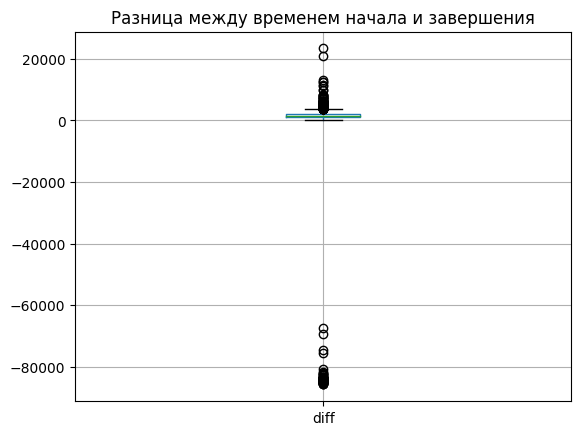

In [2993]:
beginHeatSeconds = data_arc.groupby('key').agg({'BeginHeatSeconds': ['first', 'last']})['BeginHeatSeconds']

beginHeatSeconds['diff'] = beginHeatSeconds['last'] - beginHeatSeconds['first']

beginHeatSeconds.boxplot('diff')
plt.title('Разница между временем начала и завершения')
plt.show()

In [2994]:
beginHeatSeconds['Transit'] = beginHeatSeconds['diff'] < 0
beginHeatSeconds[beginHeatSeconds['diff'] < 0].head()

,first,last,diff,Transit
key,,,,
18,83910,308,-83602,True
44,79763,4203,-75560,True
45,82957,1280,-81677,True
46,85591,11239,-74352,True
74,85684,754,-84930,True


___Примечание___: при анализе партии видно, что хронология идёт сверху вниз (т.е. первая запись в группе соотвествует первой записи события). На этом выводе и буду основывать дальнейшую обработку.

Продолжим анализ данных. После просмотра колоноки `ReactivePower` выявлено аномальное минимальное значение, изучим подробнее.

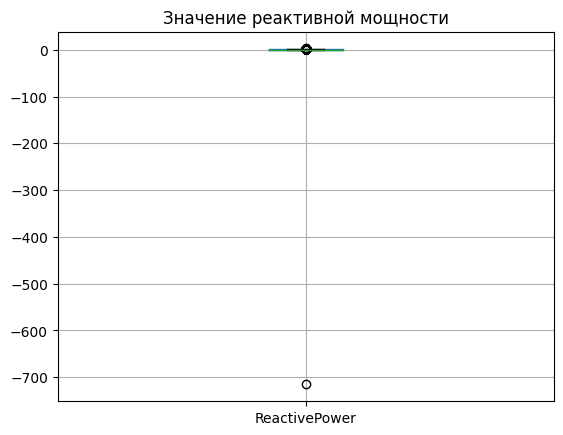

In [2995]:
data_arc.boxplot(column=['ReactivePower'])
plt.title('Значение реактивной мощности')
plt.show()

In [2996]:
condition = data_arc['ReactivePower'] < -600
data_arc[condition]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,BeginHeatHour,EndHeatHour,BeginHeatSeconds,EndHeatSeconds
9781,2116,00:44:48,00:46:37,0.495782,-715.504924,0,0,2688,2797


In [2997]:
# заменим аномальный всплеск средним значением
data_arc.loc[condition, 'ReactivePower'] = data_arc['ReactivePower'].mean()

Сгененрируем фичи

In [2998]:
def diff_seconds(row):
    """
    Вспомогательная функция для подсчёта разницы в секундах
    
    Параметры:
    ----------
    row: Serias
    
    Результат:
    int - секунды
    """
    if row['BeginHeatSeconds'] > row['EndHeatSeconds']:
        return (row['EndHeatSeconds'] + 86400) - row['BeginHeatSeconds']
    else:
        return row['EndHeatSeconds'] - row['BeginHeatSeconds']

In [2999]:
# генерация новых признаков
data_arc['DeltaHeatSeconds'] = data_arc.apply(diff_seconds, axis=1)

data_arc['TotalPower'] = data_arc['ActivePower'] + data_arc['ReactivePower']
data_arc['RelPower'] = data_arc['ActivePower'] / data_arc['ReactivePower']

In [3000]:
# проверим ещё раз распределение
data_arc[['BeginHeatSeconds', 'EndHeatSeconds', 'DeltaHeatSeconds']].describe()

,BeginHeatSeconds,EndHeatSeconds,DeltaHeatSeconds
count,14876.000000,14876.000000,14876.000000
mean,43148.600027,43192.494689,171.670946
std,24998.711157,24996.782760,98.186803
min,1.000000,7.000000,11.000000
25%,21776.750000,21793.750000,107.000000
50%,42775.000000,42832.000000,147.000000
75%,64685.750000,64730.250000,214.000000
max,86375.000000,86398.000000,907.000000


In [3001]:
# признаки по номеру партии
data_arc = data_arc.groupby('key').agg({'ActivePower': 'sum', 'ReactivePower': 'sum', 'BeginHeatSeconds': 'first', 'DeltaHeatSeconds': 'sum', 'TotalPower': 'sum', 'RelPower': 'sum', 'BeginHeat': 'count' })

In [3002]:
# добавим отметку о том, что в данной партии есть переход на новые сутки
data_arc = data_arc.merge(beginHeatSeconds['Transit'], how='inner', left_index=True, right_index=True)

In [3003]:
data_arc = data_arc.rename(columns= {'BeginHeat':'Iteration'})
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ActivePower       3214 non-null   float64
 1   ReactivePower     3214 non-null   float64
 2   BeginHeatSeconds  3214 non-null   int64  
 3   DeltaHeatSeconds  3214 non-null   int64  
 4   TotalPower        3214 non-null   float64
 5   RelPower          3214 non-null   float64
 6   Iteration         3214 non-null   int64  
 7   Transit           3214 non-null   bool   
dtypes: bool(1), float64(4), int64(3)
memory usage: 333.1 KB


In [3004]:
data_arc[data_arc['Transit']].head()

,ActivePower,ReactivePower,BeginHeatSeconds,DeltaHeatSeconds,TotalPower,RelPower,Iteration,Transit
key,,,,,,,,
18,3.495351,2.387250,83910,842,5.882601,7.295993,5,True
44,7.612617,5.861980,79763,2063,13.474597,16.005629,12,True
45,9.184464,6.563533,82957,2136,15.747997,14.205720,10,True
46,12.361625,8.369891,85591,2919,20.731517,19.046209,13,True
74,3.415471,2.637693,85684,895,6.053164,6.465400,5,True


В итоге мы получаем следующую таблицу:
* `key` - номер партии;
* `ActivePower` - значение активной мощности;
* `ReactivePower` - значение реактивной мощности;
* `BeginHeatSeconds` - время начала нагрува в секундах;
* `DeltaHeatSeconds` - время нагрува в секундах;
* `TotalPower` - сумма мощностей;
* `RelPower` - соотношение активной мощности к реактивной;
* `Iteration` - количество итераций;
* `Transit` - признак перехода на другие сутки.

#### Данные об объёме сыпучих материалов

Таблица steel.data_bulk
* key — номер партии;
* Bulk1 … Bulk15 — объём подаваемого материала.

In [3005]:
data_bulk = pd.read_csv(TMP + '/steel.data_bulk.csv')

display(data_bulk.head())

print()

data_bulk.info()

print()

data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [3006]:
# установим индекс
data_bulk = data_bulk.set_index('key')

In [3007]:
# заполним пропуски
data_bulk = data_bulk.fillna(0)

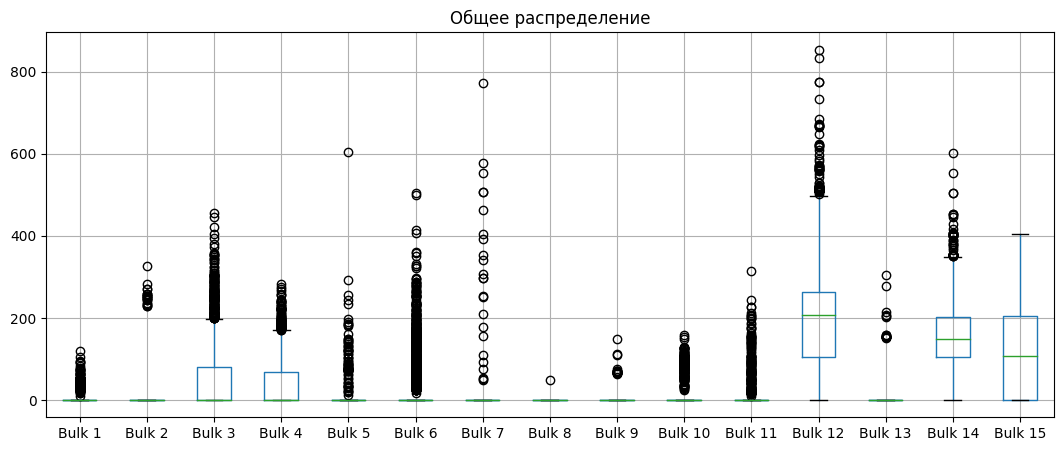

In [3069]:
data_bulk.boxplot(figsize=(13, 5))
plt.title('Общее распределение')
plt.show()

In [3068]:
# удалим всплеск
condition = (data_bulk['Bulk 12'] > 1000)
data_bulk.drop(data_bulk[condition].index, inplace=True)

#### Данные о времени подачи сыпучих материалов

Таблица steel.data_bulk_time
* key — номер партии;
* Bulk1 … Bulk15 — время подачи материала.

In [3008]:
data_bulk_time = pd.read_csv(TMP + '/steel.data_bulk_time.csv')

display(data_bulk_time.head())

print()

data_bulk_time.info()

print()

data_bulk_time.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:03:52,NaN,11:03:52,11:03:52
1,2,NaN,NaN,NaN,11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:40:20,NaN,11:40:20,11:40:20
2,3,NaN,NaN,NaN,12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:09:40,NaN,12:09:40,12:09:40
3,4,NaN,NaN,NaN,12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:41:24,NaN,12:41:24,12:41:24
4,5,NaN,NaN,NaN,13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:12:56,NaN,13:12:56,13:12:56



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [3009]:
# установим индекс
data_bulk_time = data_bulk_time.set_index('key')

In [3010]:
cols = data_bulk_time.columns

# приведём переменные Bulk N к типу time
for col in cols:
    if col.find('Bulk') >= 0:
        data_bulk_time[f'{col}'] = pd.to_datetime(data_bulk_time[col], format='%H:%M:%S').dt.time
        data_bulk_time[f'{col}'] = data_bulk_time[f'{col}'].apply(total_seconds)

Убедимся, что подача материала не измеряется сутками

In [3011]:
# 1. создадим две вспомогательные функции

def get_min_value_with_nan(row):
    return np.min(row.values, where=~np.isnan(row.values), initial=86400)

def get_max_value_with_nan(row):
    return np.max(row.values, where=~np.isnan(row.values), initial=0)

In [3012]:
# 2. выбирем колонки time для обработки
colsTime = []
for col in cols:
    if col.find('Bulk') >= 0:
        colsTime.append(f'{col}')

In [3013]:
# 3. определяем максимальное и минимальное значение
data_bulk_time['MinSecond'] = data_bulk_time[colsTime].apply(get_min_value_with_nan, axis=1)
data_bulk_time['MaxSecond'] = data_bulk_time[colsTime].apply(get_max_value_with_nan, axis=1)

In [3014]:
# 4. находим разницу
data_bulk_time['DiffSecond'] = data_bulk_time['MaxSecond'] - data_bulk_time['MinSecond']

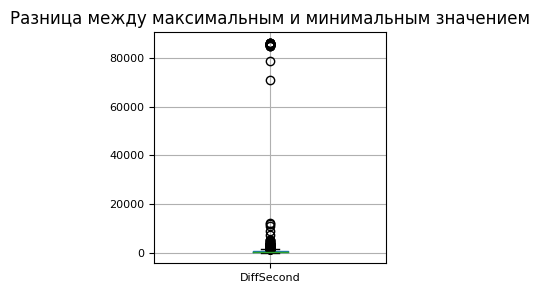

In [3015]:
data_bulk_time.boxplot('DiffSecond', figsize=(3, 3), fontsize=8)
plt.title('Разница между максимальным и минимальным значением')
plt.show()

__Вывод__: в результате анализа видны переходы через 00:00, но это не значит, что подача материала идёт сутками.

Приведём данные к относительному значению, сколько прошло времени с момента первой подачи материала

In [3016]:
condition = data_bulk_time.DiffSecond > 40000
data_bulk_time[condition]

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,MinSecond,MaxSecond,DiffSecond
key,,,,,,,,,,,,,,,,,,
44,NaN,NaN,NaN,NaN,NaN,81228.0,NaN,NaN,NaN,NaN,NaN,2375.0,2375.0,80142.0,2375.0,2375.0,81228.0,78853.0
74,NaN,NaN,NaN,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86007.0,NaN,86007.0,86007.0,110.0,86007.0,85897.0
126,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85615.0,NaN,85615.0,85615.0,1.0,85615.0,85614.0
232,NaN,NaN,NaN,NaN,93.0,NaN,NaN,NaN,NaN,NaN,NaN,85813.0,NaN,85813.0,85813.0,93.0,85813.0,85720.0
280,NaN,NaN,85906.0,NaN,NaN,NaN,NaN,NaN,296.0,NaN,NaN,84203.0,NaN,84203.0,NaN,296.0,85906.0,85610.0
641,NaN,NaN,NaN,3792.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74523.0,74523.0,NaN,74523.0,3792.0,74523.0,70731.0
642,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86175.0,NaN,86175.0,86175.0,1367.0,86175.0,84808.0
913,NaN,NaN,763.0,NaN,NaN,763.0,NaN,NaN,NaN,NaN,NaN,86258.0,NaN,86258.0,NaN,763.0,86258.0,85495.0
999,NaN,NaN,269.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86189.0,NaN,86189.0,86189.0,269.0,86189.0,85920.0


In [3017]:
# находим минимальное значение среди "переходной партии"
min_value = data_bulk_time.loc[condition, ['MinSecond']].max()['MinSecond']
min_value

3792.0

In [3018]:
data_bulk_time = data_bulk_time.fillna(-1)

for col in colsTime:
    data_bulk_time.loc[condition, col] = data_bulk_time.loc[condition, col].apply(lambda x: x + 86400 if min_value >= x and x >= 0 else x)
    
# удалим ранее созданные временные данные
data_bulk_time.drop(columns=['MinSecond', 'MaxSecond', 'DiffSecond'], inplace=True)

In [3019]:
data_bulk_time[condition].head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
44,-1.0,-1.0,-1.0,-1.0,-1.0,81228.0,-1.0,-1.0,-1.0,-1.0,-1.0,88775.0,88775.0,80142.0,88775.0
74,-1.0,-1.0,-1.0,86510.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,86007.0,-1.0,86007.0,86007.0
126,-1.0,-1.0,86401.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,85615.0,-1.0,85615.0,85615.0
232,-1.0,-1.0,-1.0,-1.0,86493.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,85813.0,-1.0,85813.0,85813.0
280,-1.0,-1.0,85906.0,-1.0,-1.0,-1.0,-1.0,-1.0,86696.0,-1.0,-1.0,84203.0,-1.0,84203.0,-1.0


In [3020]:
def get_min_value(row):
    a = np.array(row.values)
    min_value = a[a >= 0].min()
    return min_value

data_bulk_time['MinSecond'] = data_bulk_time[colsTime].apply(get_min_value, axis=1)

for col in colsTime:
    data_bulk_time[col] = data_bulk_time.apply(lambda x: x[col] - x['MinSecond'] if x[col] >= 0 else x[col], axis=1)

In [3021]:
data_bulk_time[condition].head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,MinSecond
key,,,,,,,,,,,,,,,,
44,-1.0,-1.0,-1.0,-1.0,-1.0,1086.0,-1.0,-1.0,-1.0,-1.0,-1.0,8633.0,8633.0,0.0,8633.0,80142.0
74,-1.0,-1.0,-1.0,503.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,86007.0
126,-1.0,-1.0,786.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,85615.0
232,-1.0,-1.0,-1.0,-1.0,680.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,85813.0
280,-1.0,-1.0,1703.0,-1.0,-1.0,-1.0,-1.0,-1.0,2493.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,84203.0


In [3022]:
data_bulk_time.drop(columns=['MinSecond'], inplace=True)

In [3023]:
# проверим распределение
data_bulk_time.describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,23.870566,0.543624,270.593161,207.308405,12.314797,118.364653,1.830617,-0.630233,7.678811,34.566315,38.582295,17.319271,6.113135,3.697028,16.024609
std,122.000556,40.063091,557.716422,533.844217,126.123413,353.285252,50.752566,20.683812,119.946557,204.612086,243.738618,192.667840,263.119545,76.063766,273.290559
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
75%,-1.000000,-1.000000,402.000000,300.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
max,2000.000000,1859.000000,12201.000000,15669.000000,3504.000000,5348.000000,1859.000000,1156.000000,2527.000000,4216.000000,8999.000000,8633.000000,11782.000000,2699.000000,11394.000000


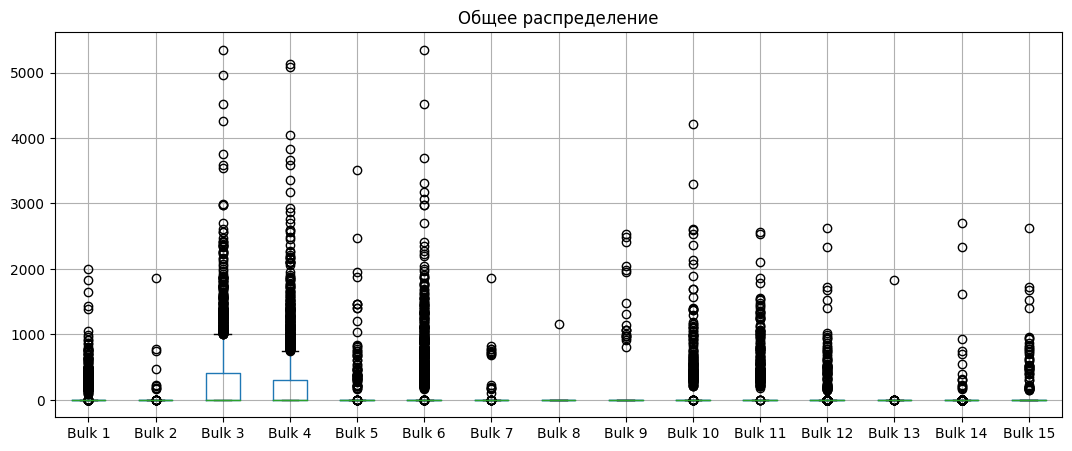

In [3066]:
data_bulk_time.boxplot(figsize=(13, 5))
plt.title('Общее распределение')
plt.show()

Удалим выбросы

In [3065]:
condition = (data_bulk_time['Bulk 3'] > 6000) | \
            (data_bulk_time['Bulk 4'] > 6000) | \
            (data_bulk_time['Bulk 11'] > 6000) | \
            (data_bulk_time['Bulk 12'] > 6000) | \
            (data_bulk_time['Bulk 13'] > 6000) | \
            (data_bulk_time['Bulk 15'] > 6000)
data_bulk_time.drop(data_bulk_time[condition].index, inplace=True)

__Вывод__: таким образом мы сгенерировали фичи, которые показывают сколько секунд прошло с момента добавления первого материала

#### Данные о продувке сплава газом

Таблица steel.data_gas
* key — номер партии;
* gas — объём подаваемого газа.

In [3024]:
data_gas = pd.read_csv(TMP + '/steel.data_gas.csv')

display(data_gas.head())

print()

data_gas.info()

print()

data_gas.describe()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB



,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [3025]:
# установим индекс
data_gas = data_gas.set_index('key')

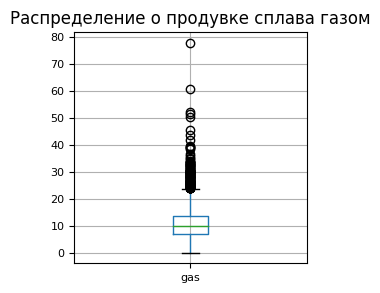

In [3026]:
data_gas.boxplot('gas', figsize=(3, 3), fontsize=8)
plt.title('Распределение о продувке сплава газом')
plt.show()

In [3027]:
condition = data_gas['gas'] > 60
data_gas[condition]

,gas
key,
280,60.935689
322,77.995040


Выявленные всплески заменим на средние значения 

In [3028]:
data_gas.loc[condition, 'gas'] = data_gas['gas'].mean()

#### Данные об измерениях температуры

Таблица steel.data_temp
* key — номер партии;
* MesaureTime — время замера;
* Temperature — значение температуры.

In [3029]:
data_temp = pd.read_csv(TMP + '/steel.data_temp.csv')

display(data_temp.head())

print()

data_temp.info()

print()

data_temp.describe()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB



,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [3030]:
# установим индекс
data_temp = data_temp.set_index('key')

In [3031]:
data_temp.head()

,MesaureTime,Temperature
key,,
1,11:16:18,1571.0
1,11:25:53,1604.0
1,11:29:11,1618.0
1,11:30:01,1601.0
1,11:30:39,1613.0


Проверим температуру

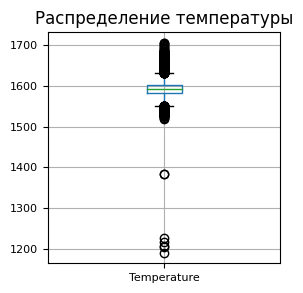

In [3032]:
data_temp.boxplot('Temperature', figsize=(3, 3), fontsize=8)
plt.title('Распределение температуры')
plt.show()

In [3033]:
# удалим аномально низкие значениея температуры в 1500
condition = data_temp['Temperature'] < 1500
data_temp[condition]

,MesaureTime,Temperature
key,,
867,14:21:00,1191.0
1214,05:32:00,1208.0
1619,11:03:54,1218.0
1818,00:30:49,1383.0
1818,00:31:40,1383.0
2052,14:51:40,1227.0
2561,07:34:15,1204.0


In [3034]:
# заменим медианной
data_temp.loc[condition, 'Temperature'] = data_temp['Temperature'].mean()

In [3035]:
# выбирем только те значения, котрые содержат как минимум два наблюдения
data_temp_filter = data_temp.groupby('key').filter(lambda x: x['Temperature'].count() > 1)

data_temp_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12265 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MesaureTime  12265 non-null  object 
 1   Temperature  12265 non-null  float64
dtypes: float64(1), object(1)
memory usage: 287.5+ KB


__Примечание__: получение последней температуры в партии основывается на том, что в выборке данные уже отсортированы в правильном порядке 

In [3036]:
# гарантируем, что значение температуры для целевого значения должно быть последним
data_temp = data_temp_filter.groupby('key').agg({ 'Temperature': 'last' })
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2475 non-null   float64
dtypes: float64(1)
memory usage: 38.7 KB


In [3037]:
data_temp.head()

,Temperature
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


#### Данные об объёме проволочных материалов

Таблица steel.data_wire
* key — номер партии;
* Wire1 … Wire15 — объём подаваемых проволочных материалов.

In [3038]:
data_wire = pd.read_csv(TMP + '/steel.data_wire.csv')

display(data_wire.head())

print()

data_wire.info()

print()

data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [3039]:
# установим индекс
data_wire = data_wire.set_index('key')

In [3040]:
# заполним пропуски
data_wire = data_wire.fillna(0)

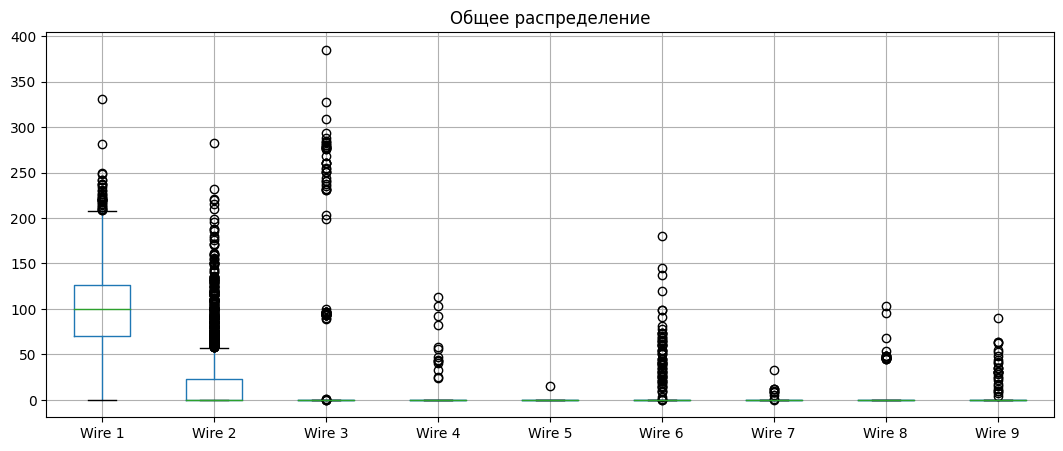

In [3070]:
data_wire.boxplot(figsize=(13, 5))
plt.title('Общее распределение')
plt.show()

#### Данные о времени подачи проволочных материалов

Таблица steel.data_wire_time
* key — номер партии;
* Wire1 … Wire15 — время подачи проволочных материалов.

In [3041]:
data_wire_time = pd.read_csv(TMP + '/steel.data_wire_time.csv')

display(data_wire_time.head())

print()

data_wire_time.info()

print()

data_wire_time.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,13:18:15,13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB



,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [3042]:
# установим индекс
data_wire_time = data_wire_time.set_index('key')

In [3043]:
cols = data_wire_time.columns

# приведём переменные Bulk N к типу time
for col in cols:
    if col.find('Wire') >= 0:
        data_wire_time[f'{col}'] = pd.to_datetime(data_wire_time[col], format='%H:%M:%S').dt.time
        data_wire_time[f'{col}'] = data_wire_time[f'{col}'].apply(total_seconds)

In [3044]:
# 2. выбирем колонки time для обработки
colsTime = []
for col in cols:
    colsTime.append(f'{col}')

In [3045]:
# 3. определяем максимальное и минимальное значение
data_wire_time['MinSecond'] = data_wire_time[colsTime].apply(get_min_value_with_nan, axis=1)
data_wire_time['MaxSecond'] = data_wire_time[colsTime].apply(get_max_value_with_nan, axis=1)

In [3046]:
data_wire_time

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,MinSecond,MaxSecond
key,,,,,,,,,,,
1,40301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40301.0,40301.0
2,42370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42370.0,42370.0
3,44027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44027.0,44027.0
4,46085.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46085.0,46085.0
5,47895.0,48726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47895.0,48726.0
...,...,...,...,...,...,...,...,...,...,...,...
3237,82220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82220.0,82220.0
3238,85104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85104.0,85104.0
3239,6643.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6643.0,6643.0


In [3047]:
# 4. находим разницу
data_wire_time['DiffSecond'] = data_wire_time['MaxSecond'] - data_wire_time['MinSecond']

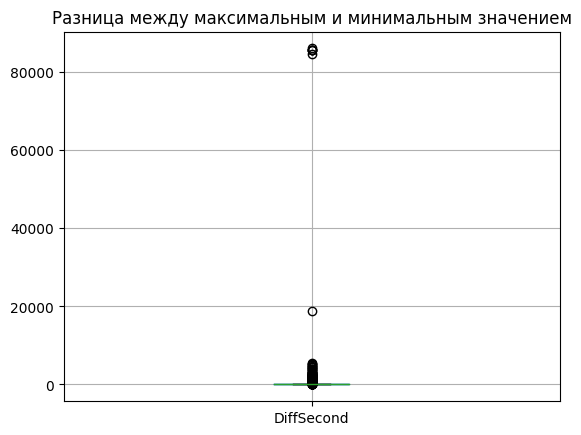

In [3048]:
data_wire_time.boxplot('DiffSecond')
plt.title('Разница между максимальным и минимальным значением')
plt.show()

__Вывод__: в результате анализа видны переходы через 00:00, но это не значит, что подача материала идёт сутками.

Приведём данные к относительному значению, сколько прошло времени с момента первой подачи материала

In [3049]:
condition = data_wire_time['DiffSecond'] > 40000
data_wire_time[condition]

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,MinSecond,MaxSecond,DiffSecond
key,,,,,,,,,,,,
280,85241.0,85924.0,NaN,NaN,NaN,NaN,NaN,212.0,NaN,212.0,85924.0,85712.0
421,86304.0,598.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,598.0,86304.0,85706.0
745,86162.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.0,86162.0,86046.0
1292,85254.0,676.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,676.0,85254.0,84578.0
1875,85887.0,338.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,338.0,85887.0,85549.0
2725,85927.0,NaN,NaN,NaN,NaN,273.0,NaN,NaN,NaN,273.0,85927.0,85654.0


In [3050]:
# находим минимальное значение среди "переходной партии"
min_value = data_wire_time.loc[condition, ['MinSecond']].max()['MinSecond']
min_value

676.0

In [3051]:
data_wire_time = data_wire_time.fillna(-1)

for col in colsTime:
    data_wire_time.loc[condition, col] = data_wire_time.loc[condition, col].apply(lambda x: x + 86400 if min_value >= x and x >= 0 else x)
    
# удалим ранее созданные временные данные
data_wire_time.drop(columns=['MinSecond', 'MaxSecond', 'DiffSecond'], inplace=True)

In [3052]:
data_wire_time[condition].head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
280,85241.0,85924.0,-1.0,-1.0,-1.0,-1.0,-1.0,86612.0,-1.0
421,86304.0,86998.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
745,86162.0,86516.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1292,85254.0,87076.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1875,85887.0,86738.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [3053]:
data_wire_time['MinSecond'] = data_wire_time[colsTime].apply(get_min_value, axis=1)

for col in colsTime:
    data_wire_time[col] = data_wire_time.apply(lambda x: x[col] - x['MinSecond'] if x[col] >= 0 else x[col], axis=1)

In [3054]:
data_wire_time[condition].head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,MinSecond
key,,,,,,,,,,
280,0.0,683.0,-1.0,-1.0,-1.0,-1.0,-1.0,1371.0,-1.0,85241.0
421,0.0,694.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,86304.0
745,0.0,354.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,86162.0
1292,0.0,1822.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,85254.0
1875,0.0,851.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,85887.0


In [3055]:
data_wire_time.drop(columns=['MinSecond'], inplace=True)

In [3056]:
# проверим распределение
data_wire_time.describe()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,24.410256,105.512821,22.220058,0.249919,0.697176,5.333333,17.366115,5.663421,1.440766
std,418.345890,305.959638,207.615054,25.875009,94.204748,96.542038,404.199767,94.476480,40.779863
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,67.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,18756.000000,5271.000000,3770.000000,835.000000,5228.000000,3973.000000,18485.000000,2361.000000,1531.000000


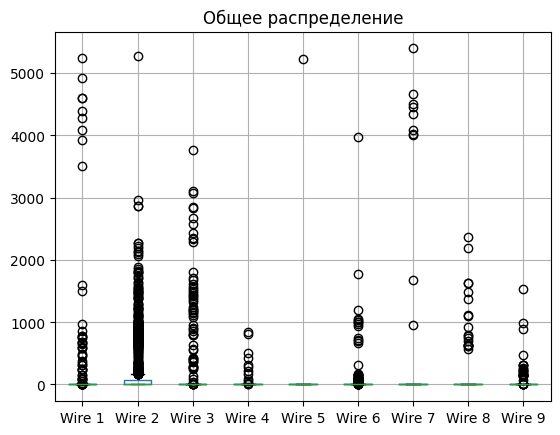

In [3060]:
data_wire_time.boxplot()
plt.title('Общее распределение')
plt.show()

Удалим всплески на `Wire 1` и `Wire 7`

In [3059]:
condition = (data_wire_time['Wire 1'] > 10000) | (data_wire_time['Wire 7'] > 10000)
data_wire_time.drop(data_wire_time[condition].index, inplace=True)

__Вывод__: таким образом мы сгенерировали фичи, которые показывают сколько секунд прошло с момента добавления первого материала